<a href="https://colab.research.google.com/github/pepogara/ENPH353_competition_nn/blob/main/ClueDetectNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import numpy as np
import re
import string
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You will need to update this path to match the folder in your Google Drive
PATH = "PATH"
# labels_raw = !ls "{PATH}"
# labels = labels_raw[0].split()

image_files = [f for f in os.listdir(PATH) if f.endswith(".png")]
print("Number of Images: " + str(len(image_files)))


Number of Images: 8


In [ ]:

### this was used to read the real comp images.
print(image_files)

for i, _ in enumerate(image_files):
    img = cv2.imread(PATH + image_files[i])
    image_files[i] = cv2.resize(img, (600,400))

['MANY.png', 'AUTUMN.png', 'PUSH.png', 'BUNNIES.png', 'FEW.png', 'SWEAR.png', 'DECELERATE.png', 'RABBITS.png']


In [ ]:
!pip freeze | grep tensorflow

tensorflow==2.9.3
tensorflow-datasets==4.9.3
tensorflow-estimator==2.9.0
tensorflow-gcs-config==2.14.0
tensorflow-hub==0.15.0
tensorflow-io-gcs-filesystem==0.34.0
tensorflow-metadata==1.14.0
tensorflow-probability==0.22.0


In [ ]:
!pip install tensorflow==2.9.3
!pip install keras==2.9.0

## Finding the right image widths for splitting

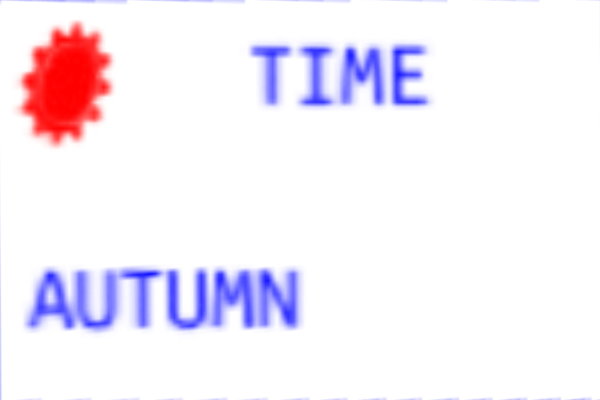

(400, 600, 3)


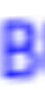

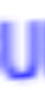

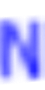

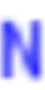

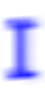

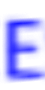

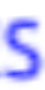

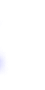

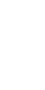

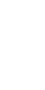

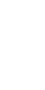

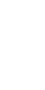

In [ ]:
#figuring out the sizes for each split

image_ranges = [(45,150),(150,255),(345,450),(450,555)]
clue_y_range = (250,340)
type_y_range = (30, 120)

char_title_range = np.arange(6,10)

img = image_files[3]
cv2_imshow(image_files[1])

print(img.shape)

start_x = 30
end_x = 75
start_y = 250
end_y = 340

# Iterate to extract 12 characters
for i in range(12):
    # Define the region of interest for each character
    char = img[start_y:end_y, start_x:end_x]

    # Display or process the character here (e.g., save it, display it, etc.)
    # For example, displaying the character:
    cv2_imshow(char)

    # Increment the x-coordinates for the next character
    start_x += 45
    end_x += 45


In [ ]:
def split_characters(image, num_chars):

    clue_y_range = (250,340)
    type_y_range = (30, 120)

    start_x = 30
    end_x = 75
    start_y = 250
    end_y = 340

    size_img = cv2.resize(image, (600, 400))

    characters = []

    # Iterate to extract characters
    for i in range(num_chars):
        # Define the region of interest for each character
        char = size_img[start_y:end_y, start_x:end_x]
        characters.append(char)

        # Increment the x-coordinates for the next character
        start_x += 45
        end_x += 45

    return characters

In [ ]:
print(image_files)

['MANY.png', 'DECELERATE.png', 'BUNNIES.png', 'SWEAR.png', 'FEW.png', 'RABBITS.png', 'PUSH.png', 'AUTUMN.png']


In [ ]:
#split chars debugging

img = cv2.imread(PATH + "0_-9KD1RB6BBE_WEAPON_blurred2.png")

split_name = "0_-9KD1RB6BBE_WEAPON_blurred2.png".split('_')
characters = split_name[1]
digits = [char if char != '-' else ' ' for char in characters]

print(digits)

test = split_characters(img, len(digits))

digit_images = []

for char_image in test:
        digit_images.append(char_image)

cv2_imshow(digit_images[10])

## Creating the Data

- Splitting the images and creating onehot vectors

In [ ]:
"""!
@brief Extract and process digit images from a list of image files.

This code reads image files, splits them into digit images, and generates one-hot encoded vectors for the digits.

@param image_files: List of image file names to process.
@param image_ranges: List of tuples specifying the pixel ranges for digit extraction.
@param char_title_range: Range of character positions in the file name to identify digits.
@param PATH: Path to the directory containing the image files.

@var digits: List of characters representing digits (0-9, A-Z).
@var one_hot_vectors: List of one-hot encoded vectors for the extracted digits.
@var digit_images: List of extracted digit images.

The code reads each image file, extracts individual digit images based on specified pixel ranges,
and determines the digits using character positions in the file name. It generates one-hot encoded vectors
for each digit and collects both the digit images and one-hot vectors in separate lists.

@var X_dataset: A copy of digit images.
@var Y_dataset: A copy of one-hot encoded vectors.

"""
digits = list(string.digits)
one_hot_vectors = []
digit_images = []


for image_file_name in image_files:
    image = cv2.imread(PATH + image_file_name)

    characters = image_file_name.replace(".png", "")

    # split_name = image_file_name.split('_')
    # characters = split_name[1]
    digits = [char if char != '-' else ' ' for char in characters]

    split_images = split_characters(image, len(digits))

    for char_image in split_images:
        digit_images.append(char_image)

    one_hot_digit_vectors = []
    for digit in digits:
        one_hot_vector = np.zeros(37)  # Assuming 37 possible characters (0-9, A-Z, ' ')
        if digit.isdigit():
            index = int(digit)
        elif digit == ' ':
            index = 36
        else:
            index = ord(digit) - ord('A') + 10  # Map A-Z to 10-35
        one_hot_vector[index] = 1
        one_hot_vectors.append(one_hot_vector)

X_dataset = np.copy(digit_images)
Y_dataset = np.copy(one_hot_vectors)

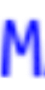

M


In [ ]:
cv2_imshow(X_dataset[0])


# cv2_imshow(cv2.imread(PATH + image_files[0]))
print(onehotToStr(Y_dataset[0]))
# print(cv2.imread(PATH + image_files[0]).shape)

## Displaying dataset contents

We are evaluating whether our data pre-processing scheme (including the one-hot-encoding and the onehot to str function) is working appropriately.

In [ ]:
def onehotToStr(one_hot_vector):
    """!
    @brief Convert a one-hot encoded vector to a string.

    This function takes a one-hot encoded vector and converts it into a string
    representation based on the characters defined in the "characters" string.

    @param one_hot_vector: One-hot encoded vector to convert to a string.

    @return: A string representation of the one-hot encoded vector.
    """
    characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ "
    decoded_strings = []

    index = np.argmax(one_hot_vector)
    character = characters[index]
    decoded_strings.append(character)

    # Join the characters to form the final string
    return ''.join(decoded_strings)

def onehotToIndex(one_hot_vector):
    """!
    @brief Convert a one-hot encoded vector to its index.

    This function takes a one-hot encoded vector and returns the index of
    the maximum value in the vector, indicating which character is encoded.

    @param one_hot_vector: One-hot encoded vector to convert to an index.

    @return: The index of the maximum value in the one-hot vector.
    """
    return np.argmax(one_hot_vector)

In [ ]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set.
def displayImage(index):
    """!
    @brief Interactive display of images from the training dataset.

    This code uses the ipywidgets library to interactively
    display images from a training dataset and their associated labels.

    The provided function should be called within an IPython or Jupyter
    Notebook environment.

    @param index: Index of the image to display.

    @return: Interactive image display with captions in an IPython or Jupyter Notebook environment.
    """

    plt.imshow(digit_images[index])
    caption = ("y = " + onehotToStr(one_hot_vectors[index]))
    plt.text(0.5, 0.5, caption,
            color='orange', fontsize = 20,
            horizontalalignment='left', verticalalignment='top')


interact(displayImage,
         index=ipywidgets.IntSlider(min=0, max=len(digit_images),
                                    step=1, value=10))

## Setting training and validation data sets

In [ ]:
"""!
@brief Split the dataset into training and validation sets.

This code splits the dataset into training and validation sets based on a
specified validation split ratio. It does not define a separate test set in this case.

The training set, 'X_train_dataset' and 'Y_train_dataset,' contains a
portion of the data for model training, while the validation set,
'X_val_dataset' and 'Y_val_dataset,' is used for model evaluation.

The code also prints information about the dataset shapes and the number of examples in each set.

@return: Training and validation sets are created for model training and evaluation.
"""

VALIDATION_SPLIT = 0.2

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

X shape: (46, 90, 45, 3)
Y shape: (46, 37)
Total examples: 46
Training examples: 37
Validation examples: 9


## Train CNN

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from tensorflow import keras as ks

### Define the model

In [ ]:
"""!
@brief Define a Convolutional Neural Network (CNN) model for character recognition.

This code defines a CNN model for character recognition. The model is designed
to classify characters into one of 36 possible classes, representing the
characters '0' to '9' and 'A' to 'Z'.

The model architecture consists of convolutional layers followed by
max-pooling layers for feature extraction and reduction. It includes fully
connected layers for classification, and the output layer uses softmax
activation for multiclass classification.

Convolutional Layers:
- First Conv2D layer with 32 filters, a 3x3 kernel, and ReLU activation.
- First MaxPooling2D layer with 2x2 pool size.
- Second Conv2D layer with 64 filters, a 3x3 kernel, and ReLU activation.
- Second MaxPooling2D layer with 2x2 pool size.
- Third Conv2D layer with 128 filters, a 3x3 kernel, and ReLU activation.
- Third MaxPooling2D layer with 2x2 pool size.
- Fourth Conv2D layer with 128 filters, a 3x3 kernel, and ReLU activation.
- Fourth MaxPooling2D layer with 2x2 pool size.

Fully Connected Layers:
- Flatten layer to transform the 2D feature maps into a 1D vector.
- Dropout layer with a dropout rate of 0.5 to prevent overfitting.
- Dense layer with 512 units and ReLU activation.

Output Layer:
- Dense layer with 'num_classes' units and softmax activation for multiclass classification.

@var LEARNING_RATE: The learning rate for the optimizer when compiling the model.
@note The model should be compiled with appropriate loss, optimizer, and metrics before training.

@return: A Keras model for character recognition with the specified architecture.
"""

# Define the number of possible outcomes
num_classes = 37  # A-Z and 0-9 and ' '

# Define your model
conv_model = models.Sequential()

# Add Convolutional and Pooling Layers
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(90, 45, 3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))

# Flatten and add Fully Connected Layers
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))

# Output Layer for 36 classes with softmax activation
conv_model.add(layers.Dense(num_classes, activation = 'softmax'))

LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 43, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 19, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 9, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 7, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 3, 128)        0

In [ ]:
def reset_weights(model):
    """!
    @brief Reset weights of a Keras model to their initial values.

    This function resets the weights of a Keras model to their
    initial values based on the initializers defined for each layer.

    @param model: A Keras model for which the weights need to be reset.

    The function iterates through the layers of the provided Keras model and
    checks if they have kernel and bias initializers. If so, it retrieves
    the initializers and the old weights and biases for each layer. It then sets
    the layer's weights to new values generated by the initializers with the same
    shapes as the old weights and biases.

    @note The model should be compiled before using this function.

    @return: The Keras model with its weights reset to their initial values.
    """
    for ix, layer in enumerate(model.layers):
        if (hasattr(model.layers[ix], 'kernel_initializer') and
            hasattr(model.layers[ix], 'bias_initializer')):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

In [ ]:
conv_model = ks.models.load_model("/content/drive/MyDrive/UBC/ENPH/ENPH 353/Competition NN/signNN_4.h5")

In [ ]:
"""!
@brief Reset model weights and train the convolutional neural network.

This code resets the weights of the 'conv_model' and then trains it using the
dataset. The training process is run for a specified number of epochs with a
specified batch size, and a portion of the dataset is designated for validation
using the 'VALIDATION_SPLIT' ratio.

This code helps reinitialize the model and then proceeds to train it.

@return: Model weights are reset, and training history is stored in 'history_conv.'
"""

# reset_weights(conv_model)
# We can also run the training by specifiying the validation split directly.
history_conv = conv_model.fit(X_dataset, Y_dataset,
                              validation_split=VALIDATION_SPLIT,
                              epochs=16,
                              batch_size=16)

Epoch 1/16
3/3 [==============================] - 3s 338ms/step - loss: 0.5176 - acc: 0.9444 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/16
3/3 [==============================] - 0s 17ms/step - loss: 4.9670e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/16
3/3 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/16
3/3 [==============================] - 0s 18ms/step - loss: 0.1230 - acc: 0.9722 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/16
3/3 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/16
3/3 [==============================] - 0s 17ms/step - loss: 0.4429 - acc: 0.9722 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/16
3/3 [==============================] - 0s 29ms/step - loss: 7.6085e-06 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 8/16
3/3 [==============================] - 0s

## Test Model

In [ ]:
from IPython.display import display, clear_output

# Display images in the training data set.
def displayImage(index):
    """!
    @brief Interactive display of images and their predictions from the training dataset.

    This code utilizes IPython to interactively display images from a
    training dataset and provides predictions for those images using a
    pre-trained convolutional neural network (CNN) model.

    @param index: Index of the image to display and predict.

    This code creates an interactive interface for exploring the training
    dataset and visualizing model predictions.

    @return: Interactive image display with ground truth and predicted
    labels in an IPython environment.
    """
    clear_output(wait=True)

    img = X_dataset[index]

    img_aug = np.expand_dims(img, axis=0)
    y_predict = conv_model.predict(img_aug)[0]

    fig, ax = plt.subplots()
    ax.imshow(img)
    caption = ("Truth: " + onehotToStr(Y_dataset[index]) +
               "\nPredicted: " + onehotToStr(y_predict))
    ax.text(0.5, 0.5, caption,
            color='orange', fontsize = 16,
            horizontalalignment='left', verticalalignment='bottom')

    plt.show()


interact(displayImage,
        index=ipywidgets.IntSlider(min=0, max=len(X_dataset),
                                   step=1, value=10))

interactive(children=(IntSlider(value=10, description='index', max=12536), Output()), _dom_classes=('widget-in…

<function __main__.displayImage(index)>

## SAVE THE MODEL

In [ ]:
conv_model.save("/content/drive/MyDrive/UBC/ENPH/ENPH 353/Competition NN/signNN_4.h5")

## Testing the model with data

In [ ]:
conv_model_test = ks.models.load_model("/content/drive/MyDrive/UBC/ENPH/ENPH 353/Competition NN/signNN_4.h5")


In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/UBC/ENPH/ENPH 353/Competition NN/Sign Pictures/real_images/bright_hint.jpg")
print("current image size: " + str(test_img.shape))

resized_image = cv2.resize(test_img, (600, 400))

# cv2_imshow(resized_image)
# resized_image.shape

characters = split_characters(resized_image, 12)

cv2_imshow(resized_image)


for i in range(12):
    img = characters[i]

    img_aug = np.expand_dims(img, axis=0)
    y_predict = conv_model_test.predict(img_aug)[0]

    fig, ax = plt.subplots()
    ax.imshow(img)
    caption = ("Predicted: " + onehotToStr(y_predict))
    print(y_predict)
    ax.text(0.5, 0.5, caption,
            color='orange', fontsize = 16,
            horizontalalignment='left', verticalalignment='bottom')

    plt.show()


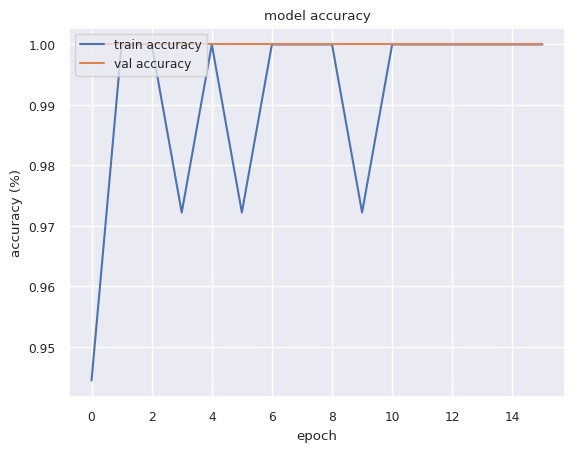

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred_probabilities = conv_model_test.predict(X_dataset)
y_pred = [onehotToIndex(y_pred_probabilities[i]) for i in range(len(y_pred_probabilities))]
y_true = [onehotToIndex(Y_dataset[i]) for i in range(len(Y_dataset))]

confusion_mat = confusion_matrix(y_true, y_pred)
cm_data = pd.DataFrame(confusion_mat, index = [i for i in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ "],
                                columns = [i for i in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ "])

639/639 [==============================] - 3s 3ms/step


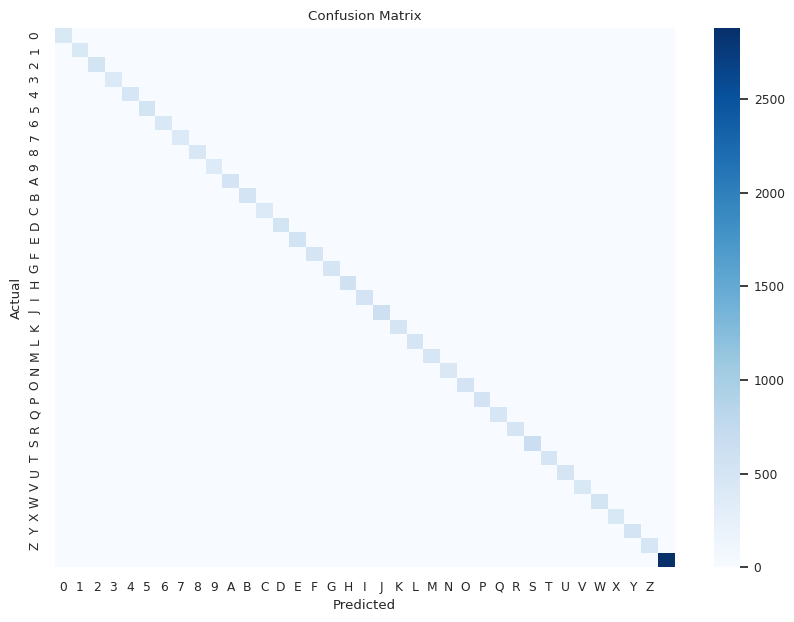

In [ ]:
plt.figure(figsize=(10, 7))

sns.set(font_scale=.8)
sns.heatmap(cm_data, annot=False, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()